In [34]:
!python -m pip install yfinance
import torch.nn as nn
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import random
from copy import deepcopy as dc
import math
import warnings
import yfinance as yf
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr


warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


In [35]:
lookback = 2
batch_size = 32

input_size = 1
hidden_size = 32
output_size = 1
num_stacked_layers = 1
loss_function = nn.L1Loss(reduction='mean')
dropout = 0.0

learning_rate = 0.0001
my_optimizer = torch.optim.Adam
num_epochs = 50

window_size = 1

train_size = 0.9
valid_size = 0.05

batch_print_idx = 50

linear_lookback = 4

In [36]:
symbol = '^GSPC'
start_date = '1915-01-01'
end_date = '2023-12-30'
date_column_name = 'Date'

data = yf.download(symbol, start=start_date, end=end_date, interval='1d')
data.reset_index(inplace=True)
data


[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...,...,...
24110,2023-12-22,4753.919922,4772.939941,4736.770020,4754.629883,4754.629883,3046770000
24111,2023-12-26,4758.859863,4784.720215,4758.450195,4774.750000,4774.750000,2513910000
24112,2023-12-27,4773.450195,4785.390137,4768.899902,4781.580078,4781.580078,2748450000
24113,2023-12-28,4786.439941,4793.299805,4780.979980,4783.350098,4783.350098,2698860000


In [37]:
data = data[[date_column_name, 'Close']]
data

,Date,Close
0,1927-12-30,17.660000
1,1928-01-03,17.760000
2,1928-01-04,17.719999
3,1928-01-05,17.549999
4,1928-01-06,17.660000
...,...,...
24110,2023-12-22,4754.629883
24111,2023-12-26,4774.750000
24112,2023-12-27,4781.580078
24113,2023-12-28,4783.350098


In [38]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

C:\Users\dfgdfg\AppData\Local\Temp\ipykernel_1388\1660152560.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sort_values(by=date_column_name, inplace=True)


(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.]),
 [Text(0, -1000.0, '−1000'),
  Text(0, 0.0, '0'),
  Text(0, 1000.0, '1000'),
  Text(0, 2000.0, '2000'),
  Text(0, 3000.0, '3000'),
  Text(0, 4000.0, '4000'),
  Text(0, 5000.0, '5000'),
  Text(0, 6000.0, '6000')])

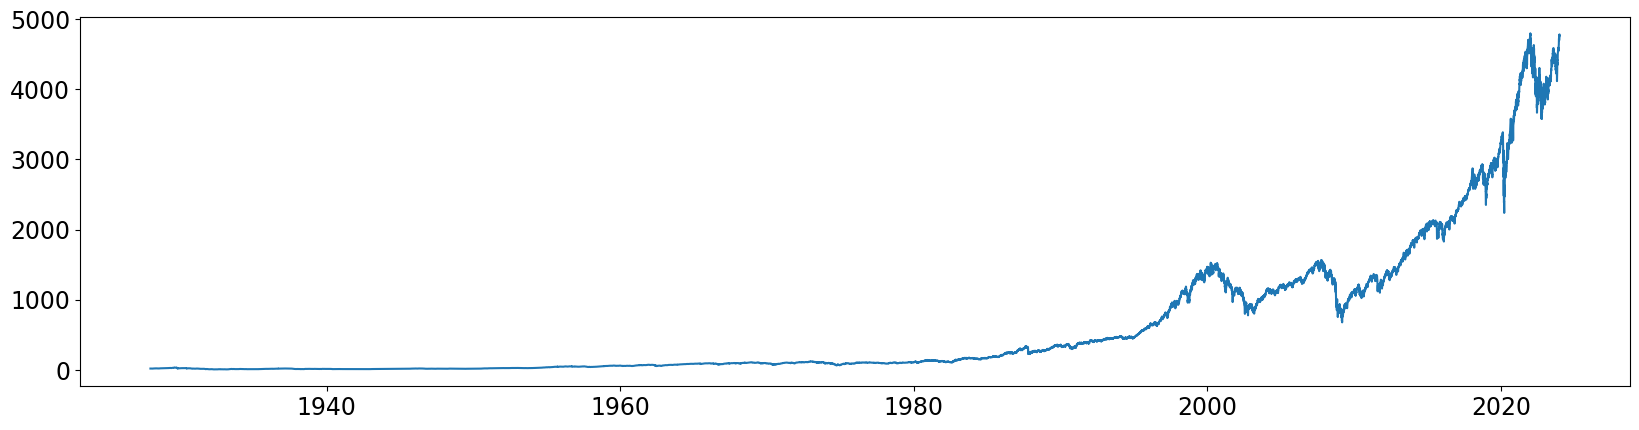

In [39]:
data.sort_values(by=date_column_name, inplace=True)
plt.figure().set_figwidth(20)
plt.plot(data[date_column_name], data['Close'])
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)

In [40]:
def scale_list_to_01(value_list):
    value_min = min(value_list)
    value_max = max(value_list)
    return [(value - value_min) / (value_max - value_min) for value in value_list], value_min, value_max

def scale_list_back_to_original(scaled_list, original_min, original_max):
    return [scaled_value * (original_max - original_min) + original_min for scaled_value in scaled_list]

In [41]:
close_values = data['Close'].tolist()
scaled_data_column, original_min, original_max = scale_list_to_01(close_values)

scaled_data = dc(data)
scaled_data['Close'] = scaled_data_column

scaled_data.shape

(24115, 2)

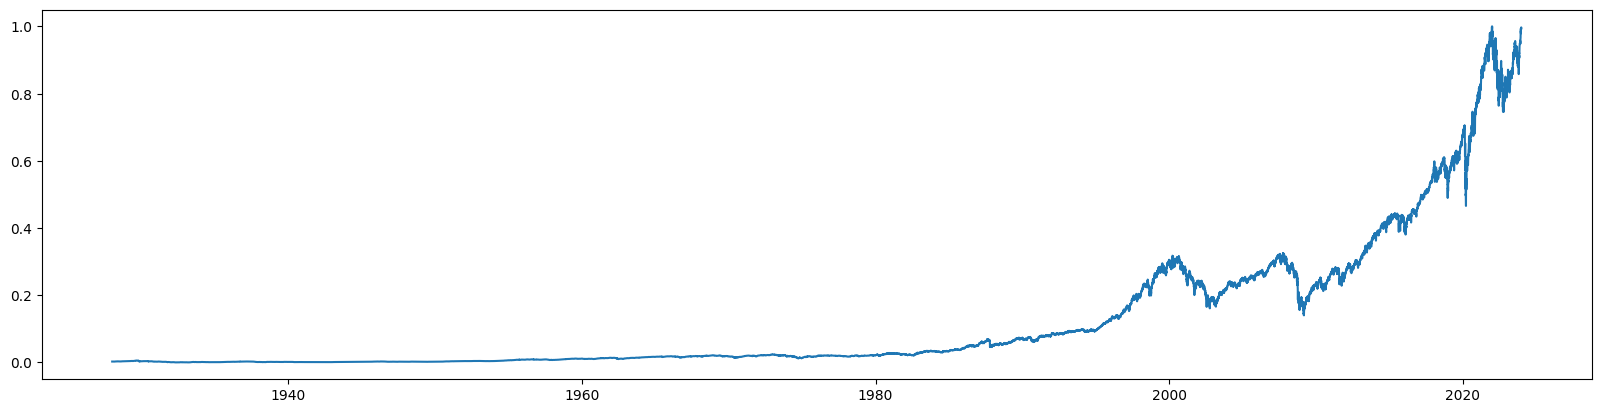

In [42]:
plt.figure().set_figwidth(20)
plt.plot(scaled_data[date_column_name], scaled_data['Close'])

In [43]:
def prepare_dataframe_for_lstm(df, n_steps_back):
    df = dc(df)
    df.set_index(date_column_name, inplace=True)
    df = df.interpolate(method='nearest')

    for i in range(1, n_steps_back + 1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

scaled_data = prepare_dataframe_for_lstm(scaled_data, lookback).to_numpy()
scaled_data.shape

(24113, 3)

In [44]:
total_size = len(data)
train_size = int(train_size * total_size)
valid_size = int(valid_size * total_size)

X_train = scaled_data[:train_size, 1:]
y_train = scaled_data[:train_size, 0]

X_valid = scaled_data[train_size:train_size + valid_size, 1:]
y_valid = scaled_data[train_size:train_size + valid_size, 0]

X_test = scaled_data[train_size + valid_size:, 1:]
y_test = scaled_data[train_size + valid_size:, 0]

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((21703, 2), (21703,), (1205, 2), (1205,), (1205, 2), (1205,))

In [45]:
#flip so that values go from lookback to prediction
X_train = dc(np.flip(X_train, axis=1))
X_valid = dc(np.flip(X_valid, axis=1))
X_test = dc(np.flip(X_test, axis=1))

In [46]:
X_train = X_train.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1, 1))

X_valid = X_valid.reshape((-1, lookback, 1))
y_valid = y_valid.reshape((-1, 1))

X_test = X_test.reshape((-1, lookback, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape, y_valid.shape, y_valid.shape

((21703, 2, 1), (1205, 2, 1), (21703, 1), (1205, 1), (1205, 1), (1205, 1))

In [47]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

X_valid = torch.tensor(X_valid).float()
y_valid = torch.tensor(y_valid).float()

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

(torch.Size([21703, 2, 1]),
 torch.Size([21703, 1]),
 torch.Size([1205, 2, 1]),
 torch.Size([1205, 1]),
 torch.Size([1205, 2, 1]),
 torch.Size([1205, 1]))

In [48]:
class TimeSeriesData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]


train_dataset = TimeSeriesData(X_train, y_train)
valid_dataset = TimeSeriesData(X_valid, y_valid)
test_dataset = TimeSeriesData(X_test, y_test)

train_dataset, valid_dataset, test_dataset

(<__main__.TimeSeriesData at 0x107dcbf93c0>,
 <__main__.TimeSeriesData at 0x107db29a560>)

In [49]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_loader, valid_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x107d8930130>,
 <torch.utils.data.dataloader.DataLoader at 0x107db8c0070>)

In [50]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, output_size, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.output_size = output_size

        self.rnn = nn.GRU(input_size, hidden_size, num_stacked_layers, dropout=dropout, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.num_stacked_layers, batch_size, self.hidden_size).zero_().to(device)
        return hidden

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.rnn(x, h0)

        out = self.fc(out[:, -1, :])

        return out

In [51]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    running_loss_all = 0.0

    for batch_index, batch in enumerate(train_loader):
      x_batch, y_batch = batch[0].to(device), batch[1].to(device)

      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()
      running_loss_all += loss.item()

      optimizer.zero_grad() # original
      loss.backward()
      optimizer.step()

      if batch_index % batch_print_idx == batch_print_idx - 1:
          avg_loss_across_batches = running_loss / batch_print_idx
          print('Batch {0}, Loss: {1:.6f}'.format(batch_index+1,
                                                  avg_loss_across_batches))
          running_loss = 0.0

    print('***************************************************')
    print('Train Loss: {0:.6f}'.format(running_loss / len(train_loader)))
    train_loss_arr.append(running_loss_all / len(train_loader))
    print()

In [52]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(valid_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(valid_loader)
    valid_loss_arr.append(avg_loss_across_batches)

    print('Val Loss: {0:.6f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [53]:
valid_loss_arr = []
train_loss_arr = []

In [54]:
model = LSTM(input_size, hidden_size, num_stacked_layers, output_size, dropout)
optimizer = my_optimizer(model.parameters(), lr=learning_rate)
model.to(device)

model, model.parameters()

(LSTM(
   (rnn): GRU(1, 32, batch_first=True)
   (fc): Linear(in_features=32, out_features=1, bias=True)
 ),
 <generator object Module.parameters at 0x00000107DB2C6AB0>)

In [55]:
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 50, Loss: 0.001502
Batch 100, Loss: 0.000458
Batch 150, Loss: 0.000335
Batch 200, Loss: 0.000386
Batch 250, Loss: 0.000655
Batch 300, Loss: 0.001249
Batch 350, Loss: 0.002288
Batch 400, Loss: 0.002992
Batch 450, Loss: 0.002794
Batch 500, Loss: 0.006295
Batch 550, Loss: 0.022273
Batch 600, Loss: 0.082796
Batch 650, Loss: 0.044743
***************************************************
Train Loss: 0.002183

Val Loss: 0.178100
***************************************************

Epoch: 2
Batch 50, Loss: 0.209327
Batch 100, Loss: 0.158600
Batch 150, Loss: 0.110385
Batch 200, Loss: 0.064116
Batch 250, Loss: 0.016806
Batch 300, Loss: 0.001096
Batch 350, Loss: 0.002124
Batch 400, Loss: 0.002658
Batch 450, Loss: 0.002387
Batch 500, Loss: 0.005381
Batch 550, Loss: 0.018627
Batch 600, Loss: 0.070286
Batch 650, Loss: 0.037765
***************************************************
Train Loss: 0.001763

Val Loss: 0.149762
***************************************************

Epoch: 3
Batch 5

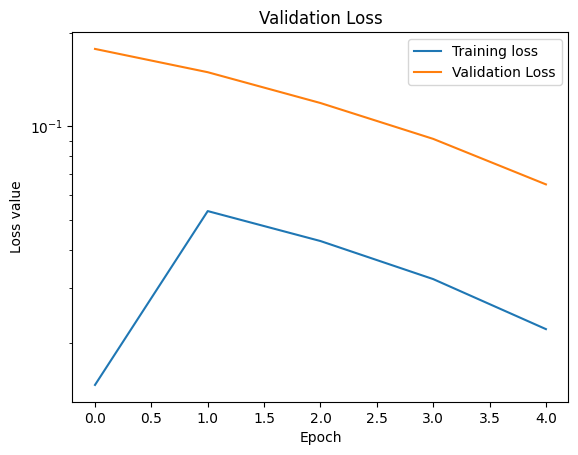

In [56]:
# Training Loss
plt.plot(train_loss_arr, label='Training loss')
plt.yscale('log')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend()

# Test Loss
plt.plot(valid_loss_arr, label='Validation Loss')
plt.yscale('log')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.legend()

plt.show()


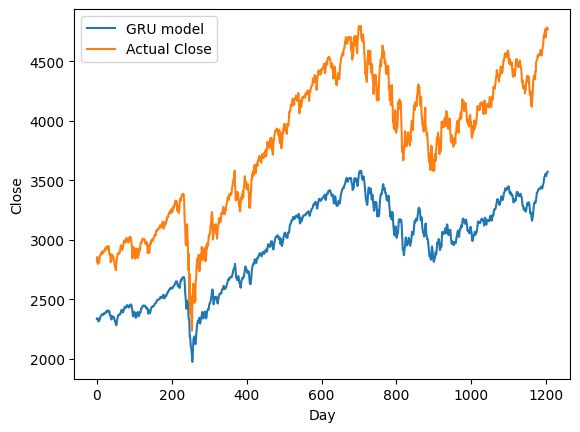

In [57]:
x_all = []
y_all = []

model.eval()
with torch.no_grad():
    for batch_index, batch in enumerate(test_loader):
        x_batch = batch[0].to(device)
        y_batch = batch[1].to('cpu')

        predicted = model(x_batch).to('cpu').numpy()

        x_all.extend(predicted.tolist())
        y_all.extend(y_batch.tolist())

x_all = [item for sublist in x_all for item in sublist]
y_all = [item for sublist in y_all for item in sublist]

predictions_scaled_back = scale_list_back_to_original(x_all, original_min, original_max)
true_values_scaled_back = scale_list_back_to_original(y_all, original_min, original_max)

# Plotting all data in one plot
plt.plot(predictions_scaled_back, label='GRU model')
plt.plot(true_values_scaled_back, label='Actual Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [58]:
def direction(y_true, y_pred):
  correct = 0
  same = 0
  total = len(y_true)

  for i in range(1, total):
    if (y_true[i] > y_true[i-1] and y_pred[i] > y_true[i-1]) or \
       (y_true[i] == y_true[i-1] and y_pred[i] == y_true[i-1]) or \
       (y_true[i] < y_true[i-1] and y_pred[i] < y_true[i-1]):
       correct += 1

  return correct / (total - 1)

In [59]:
def my_mean_absolute_error(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)

    errors = np.abs(actual - forecast)
    mae = np.sum(errors) / len(errors)
    return mae

def my_mean_relative_error(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)

    errors = np.abs(actual - forecast) / actual
    return np.mean(errors)

In [60]:
def calculate_linear_regression(x, y):
    if len(x) < 2 or len(y) < 2:
      return np.nan

    x = np.array(x).reshape(-1, 1)
    reg = LinearRegression().fit(x, y)

    new_value = reg.predict([[len(x)]])
    return new_value[0]

original_prices = true_values_scaled_back
linear_predictions = []

for i in range(0, len(original_prices)):
    y = original_prices[i:i+linear_lookback]
    x = list(range(len(y)))

    new_value = calculate_linear_regression(x, y)
    linear_predictions.append(new_value)

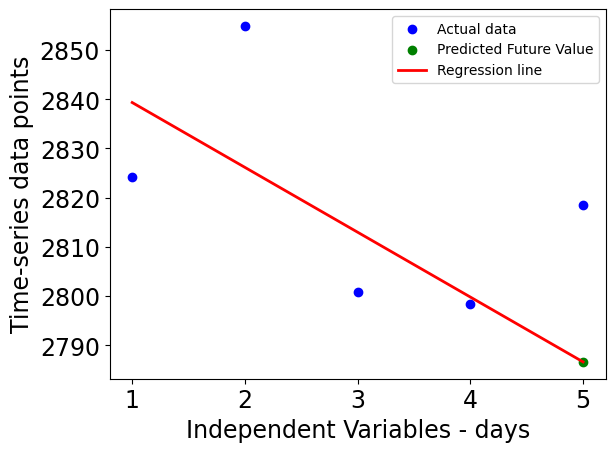

In [61]:
lookback_test = linear_lookback

y = np.array(original_prices[0:lookback_test])
x = np.arange(1, len(y) + 1)

x = x.reshape(-1, 1)

model_lr = LinearRegression()
model_lr.fit(x, y)
predictions = model_lr.predict(x)

y_real = np.array(original_prices[0:lookback_test + 1])
x_real = np.arange(1, len(y_real) + 1)

plt.scatter(x_real, y_real, color='blue', label='Actual data')

future_x = np.array([lookback_test + 1])
future_x = future_x.reshape(-1, 1)
future_y = model_lr.predict(future_x)

plt.scatter(future_x, future_y, color='green', marker='o', label='Predicted Future Value')

x = np.append(x, future_x)
predictions = np.append(predictions, future_y)
plt.plot(x, predictions, color='red', linewidth=2, label='Regression line')
plt.xticks(range(min(x), max(x) + 1))

plt.xlabel('Independent Variables - days', fontsize=17)
plt.ylabel('Time-series data points', fontsize=17)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend()
plt.show()


Mean Absolute Error (MAE) model: 852.323
Mean Absolute Error (MAE) linear: 39.4691
Mean Absolute Error (MAE) dummy: 32.6817

Mean Relative Error (MRE) model: 0.219903
Mean Relative Error (MRE) linear: 0.010666
Mean Relative Error (MRE) dummy: 0.008927

Correct direction count percentage model: 0.45955
Correct direction count percentage linear: 0.507089


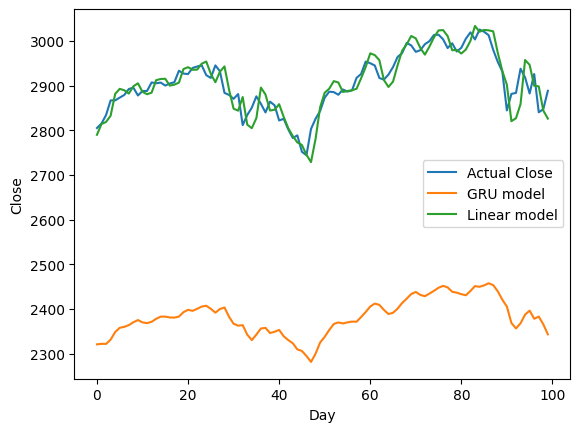

In [62]:
y_true = true_values_scaled_back[linear_lookback + 1:]
y_pred_model = predictions_scaled_back[linear_lookback + 1:]
y_pred_linear = linear_predictions[1:-linear_lookback]
y_pred_dummy = true_values_scaled_back[linear_lookback: -1]

mae_model = my_mean_absolute_error(y_true, y_pred_model)
mre_model = my_mean_relative_error(y_true, y_pred_model)
dir_model = direction(y_true, y_pred_model)

mae_linear = my_mean_absolute_error(y_true, y_pred_linear)
mre_linear = my_mean_relative_error(y_true, y_pred_linear)
dir_linear = direction(y_true, y_pred_linear)

mae_dummy = my_mean_absolute_error(y_true, y_pred_dummy)
mre_dummy = my_mean_relative_error(y_true, y_pred_dummy)

print(f"Mean Absolute Error (MAE) model: {round(mae_model, 4)}")
print(f"Mean Absolute Error (MAE) linear: {round(mae_linear, 4)}")
print(f"Mean Absolute Error (MAE) dummy: {round(mae_dummy, 4)}")
print()
print(f"Mean Relative Error (MRE) model: {round(mre_model, 6)}")
print(f"Mean Relative Error (MRE) linear: {round(mre_linear, 6)}")
print(f"Mean Relative Error (MRE) dummy: {round(mre_dummy, 6)}")
print()
print(f"Correct direction count percentage model: {round(dir_model, 6)}")
print(f"Correct direction count percentage linear: {round(dir_linear, 6)}")

start = 0
stop = 100

plt.plot(y_true[start:stop], label='Actual Close')
plt.plot(y_pred_model[start:stop], label='GRU model')
plt.plot(y_pred_linear[start:stop], label='Linear model')

plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


Mean Absolute Error (MAE) GRU vs Dummy: 850.6968147723856
Mean Relative Error (MRE) GRU vs Dummy: 0.21960875918446263


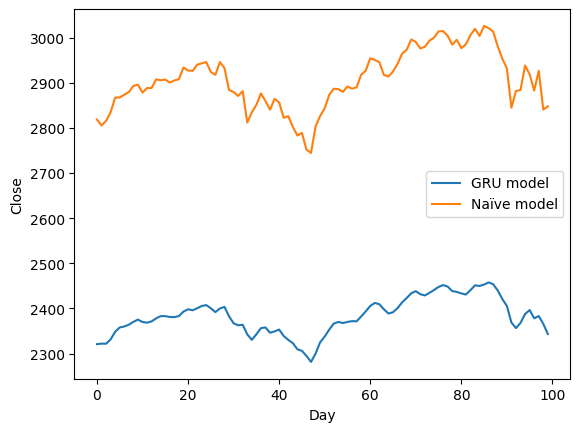

In [63]:
mae_pred_vs_dummy = my_mean_absolute_error(y_pred_dummy, y_pred_model)
mre_pred_vs_dummy = my_mean_relative_error(y_pred_dummy, y_pred_model)
print(f"Mean Absolute Error (MAE) GRU vs Dummy: {mae_pred_vs_dummy}")
print(f"Mean Relative Error (MRE) GRU vs Dummy: {mre_pred_vs_dummy}")

start = 0
stop = 100

plt.plot(y_pred_model[start:stop], label='GRU model')
plt.plot(y_pred_dummy[start:stop], label='Naïve model')

plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [64]:
# torch.save(model, "./model")